In [1]:
import pandas as pd

In [2]:
L2s = """Cellphones & Telecommunications > Mobile Phone Accessories
Cellphones & Telecommunications > Phone Bags & Cases
Home & Garden > Arts, Crafts & Sewing
Home & Garden > Festive & Party Supplies
Home & Garden > Garden Supplies
Home & Garden > Home Decor
Home & Garden > Home Textile
Home & Garden > Kitchen,Dining & Bar
Home & Garden > Pet Products
Home Improvement > Lights & Lighting
Jewelry & Accessories > Fine Jewelry
Jewelry & Accessories > Necklaces & Pendants
Jewelry & Accessories > Rings
Shoes > Women's Shoes
Sports > Fishing
Sports > Sneakers
Consumer Electronics > Earphones & Headphones
Sports > Fitness & Body Building
Sports > Hunting
Sports > Camping & Hiking
Home & Garden > Home Storage & Organization
Home & Garden > Household Merchandise
Luggage & Bags > Women's Bags
Luggage & Bags > Men's Bags
Shoes > Men's Shoes""".split('\n')

In [3]:
len(L2s)

25

In [4]:
df = pd.read_csv("Initial Attribute Definition for First Release - UPDATED SHEET .csv")

In [37]:
df[(df.category_attributevalue != df.attribute_attributevalue) & (df.category_attributevalue == "['']")]

,category,attribute_field,category_attributevalue,attribute_attributevalue,description,usage,entry mode


In [5]:
for i in L2s:
    assert len(df[df.category.apply(lambda x: x.startswith(i))]) > 0

In [6]:
df_ = df[df.category.apply(lambda x: any([x.startswith(i) for i in L2s]))]

In [7]:
len(df_) / len(df)

0.5351860725123783

In [8]:
df = df_

In [9]:
df =df[['category', 'attribute_field', 'category_attributevalue', 'attribute_attributevalue', 'description', 'usage', 'entry mode']]

<AxesSubplot: ylabel='usage'>

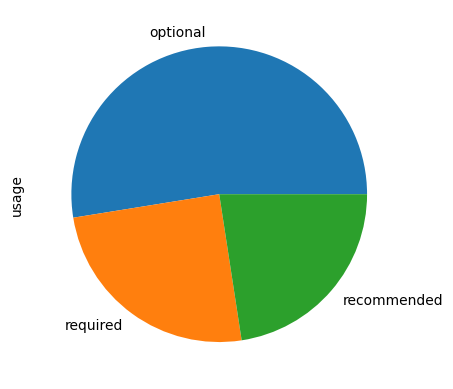

In [10]:
df.usage.value_counts().plot.pie()

<AxesSubplot: ylabel='entry mode'>

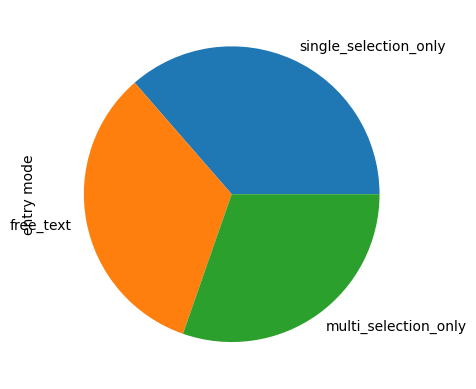

In [11]:
df['entry mode'].value_counts().plot.pie()

<AxesSubplot: ylabel='usage'>

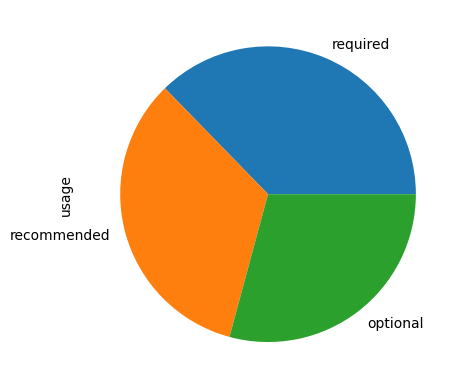

In [12]:
df[df['entry mode'].apply(lambda x: x != 'free_text')].usage.value_counts().plot.pie()

<AxesSubplot: ylabel='Frequency'>

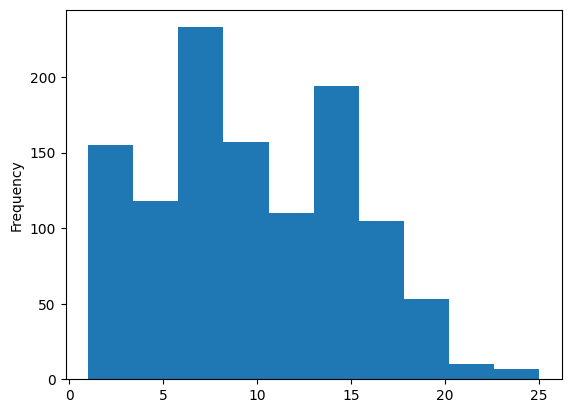

In [13]:
df[df['entry mode'].apply(lambda x: x != 'free_text')].groupby('category').count()['attribute_field'].plot.hist()

<AxesSubplot: ylabel='Frequency'>

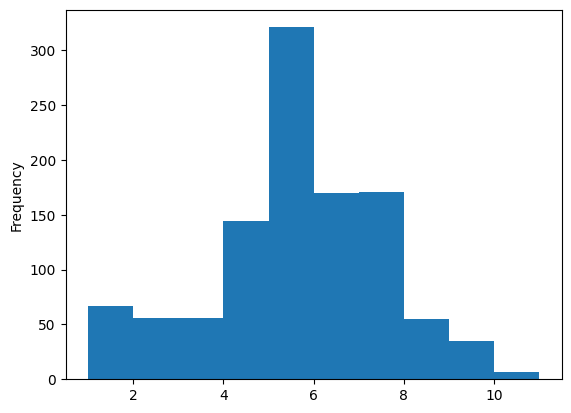

In [14]:
df[df['entry mode'].apply(lambda x: x == 'free_text')].groupby('category').count()['attribute_field'].plot.hist()

In [17]:
len(set(df[df['entry mode'].apply(lambda x: x == 'free_text')]['attribute_field']))

112

In [19]:
bad_attributes = [
    'Certificate Number',
    'Certificate Type',
    'Certification',
    'Model or Model Number'
]

In [26]:
df[(df['category'] == 2) & (df['entry mode'] != 'free_text')].sample(frac=1.).head(2)

,category,attribute_field,category_attributevalue,attribute_attributevalue,description,usage,entry mode


In [59]:
from langchain.llms import OpenAI
from tqdm import tqdm

In [74]:
llm = OpenAI(model_name='text-davinci-003', temperature=0, max_tokens=256)

In [79]:
unit_of_measure_dict = {}
augmented_attr_vals = []
for i in tqdm(df[df['entry mode'].apply(lambda x: x == 'free_text')].sample(frac=1., random_state=42).to_dict('records')):
    if i['attribute_field'] in unit_of_measure_dict or i['attribute_field'] in bad_attributes:
        continue
    try:
        df_prompt_fewshot = df[(df['category'] == i['category']) & (df['entry mode'] != 'free_text') & (df.category_attributevalue != "['']")].sample(
            frac=1., random_state=42).head(3)
        prompt_fewshot = '\n'.join([f"- {j['attribute_field']}: {j['category_attributevalue']}" for j in df_prompt_fewshot.to_dict('records')])
        prompt = \
f"""Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> {i['category']}
{prompt_fewshot}
{i['description']} (output a Python list of strings)
- {i['attribute_field']}:"""
        res = llm(prompt, stop=['\n'])
        if "Include Unit of Measure" in i['attribute_field']:
            unit_of_measure_dict[i['attribute_field']] = res.strip()
        else:
            i['category_attributevalue_augmented'] = res.strip()
            augmented_attr_vals.append(i)
    except Exception as e:
        print(e) 
        print(prompt)


  1%|          | 46/5572 [01:43<10:59:59,  7.17s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Pet Products > Dog Clothing & Shoes > Dog Raincoats
- Theme: ['Aliens', 'Animals', 'Anime', 'Beverages', 'Birds', 'Cartoon', 'Celebrity', 'Circus', 'Cowboys', 'Doctor', 'Fantasy', 'Firefighters', 'Fish', 'Food & Beverage', 'Fruit', 'Horror', 'Insects', 'Jail', 'Mailman', 'Military', 'Motorcycle', 'Ninjas', 'Nurse', 'Pirates', 'Police', 'Sailor', 'Scarecrow', 'Sherpa', 'Snack', 'Space', 'Sports', 'Superheroes', 'TV & Movies', 'Vegetables', 'Vikings']
- Season: ['All', 'Fall', 'Fall/Winter', 'Non-seasonal', 'Spring', 'Spring/Fall', 'Spring/Summer', 'Spring/Summer/Fall', 'Summer', 'Winter']
- Alpha Size: ['10XL', '2XL', '2XS', '3XL', '4XL', '5XL', '6XL', '7XL', '8XL', '9XL', 'L', 'M', 'One Size', 'S', 'XL', 'XS']
Specifies the brand or manufacturer of the product. (output a Python list of strings)
- Bra

  4%|▍         | 234/5572 [05:23<7:34:11,  5.11s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Sports > Camping & Hiking > Hiking Caps
- Styles: ['Baguette', 'Hobo', 'Satchel', 'Tote']
- Body Closure: ['Adjustable', 'Backstrap', 'Belted', 'Buckle', 'Bungee', 'Button', 'Button End', 'Button Fly', 'Clamp', 'Clasp', 'Clip', 'Clips', 'D-Ring', 'Double D-Ring', 'Double Ring', 'Drawstring', 'Elastic', 'Flap', 'Flat Solid Buckle', 'Flip', 'Fold', 'Hook and Bar', 'Hook and Eye', 'Hook and Loop', 'J-Clip', 'Kiss Lock', 'Lace Up', 'Lobster Claw', 'Magnetic', 'No Closure', 'Pull-On', 'Pull-Through', 'Push Lock', 'Ratchet', 'Round Classic Ring', 'Screw', 'Self Tie', 'Slip-On', 'Snap', 'Speed Laces', 'Square Classic Ring', 'Tie', 'Toggle', 'Turn Lock', 'Twist Lock', 'Velcro', 'Zipper']
- Primary Color: ['Beige', 'Black', 'Blue', 'Brass', 'Bronze', 'Brown', 'Caramel', 'Clear', 'Copper', 'Dark Beige', 'Dark Blue', 'Dark Bro

  9%|▊         | 484/5572 [09:53<4:21:19,  3.08s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Festive & Party Supplies > Artificial Decorations > Artificial & Dried Flowers
- Placement: ['Desktop', 'Floor', 'Hanging', 'Panels and Mats']
- Intended Usage: ['Aquarium', 'Car Decor', 'Exhibition', 'Home Decor', 'Hotel Decor', 'Indoor', 'Office Decor', 'Outdoor']
- Age Range Description: ['Adult', 'All Ages', 'Infant', 'Kids', 'Teen', 'Toddler']
Specifies any additional styling details of the item that are not included in the attribute definition. (output a Python list of strings)
- Styling:


  9%|▉         | 510/5572 [11:03<9:41:38,  6.89s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Kitchen,Dining & Bar > Cheese Tools > Cheese Knives
- Is Dishwasher Safe: ['No', 'Yes']
- Alpha Size: ['10XL', '2XL', '2XS', '3XL', '4XL', '5XL', '6XL', '7XL', '8XL', '9XL', 'L', 'M', 'One Size', 'S', 'XL', 'XS']
- Materials: ['18/10 Steel', '18/8 Stainless Steel', '18/8 Steel', 'Acacia Wood', 'Acrylic', 'Acrylic Coated Cotton', 'Acrylonitrile Butadiene Styrene (ABS)', 'Agate', 'Alder', 'Alloy', 'Alloy Steel', 'Aluminum', 'Bamboo', 'Bamboo-Derived Rayon', 'Beech Wood', 'Birch Wood', 'Bone China', 'Borosilicate Glass', 'Brass', 'Bronze', 'Burlap', 'Canvas', 'Carbon', 'Carbon Steel', 'Cardboard', 'Cashmere', 'Cast Iron', 'Cedar Wood', 'Ceramic', 'Ceramic Glass', 'Chenille', 'Cherry Wood', 'Chiffon', 'Chrome', 'Chromium Steel', 'Clay', 'Cloth', 'Copper', 'Copper-Plated', 'Cork', 'Cotton', 'Cotton Blend'

 13%|█▎        | 698/5572 [14:50<4:28:09,  3.30s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Jewelry & Accessories > Rings
- Styles: ['Baguette', 'Hobo', 'Satchel', 'Tote']
- Size: ['0', '0.5', '1', '1.5', '10', '10.25', '10.5', '10.75', '11', '11.25', '11.5', '11.75', '12', '12.25', '12.5', '12.75', '13', '13.25', '13.5', '13.75', '14', '14.25', '14.5', '14.75', '15', '15.25', '15.5', '15.75', '16', '16.25', '16.5', '16.75', '17', '17.25', '17.5', '17.75', '18', '18.25', '18.5', '18.75', '19', '19.25', '19.5', '19.75', '2', '2.5', '20', '20.5', '21', '21.5', '22', '22.5', '23', '23.5', '24', '24.5', '25', '25.5', '26', '26.5', '27', '27.5', '28', '28.5', '29', '29.5', '2XL', '2XS', '3', '3.25', '3.5', '3.75', '30', '30.5', '31', '31.5', '32', '32.5', '33', '3XL', '4', '4.25', '4.5', '4.75', '4XL', '5', '5.25', '5.5', '5.75', '5XL', '6', '6.25', '6.5', '6.75', '7', '7.25', '7.5', '7.75', '8', '8.25', '8.5',

 13%|█▎        | 738/5572 [16:15<4:34:18,  3.40s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Household Merchandise > Rain Gear > Umbrella Stands
- Materials: ['Acrylic', 'Acrylonitrile Butadiene Styrene (ABS)', 'Alloy Steel', 'Aluminum', 'Bamboo', 'Beech Wood', 'Birch Wood', 'Brass', 'Bronze', 'Canvas', 'Carbon Steel', 'Cashmere', 'Cast Iron', 'Cedar Wood', 'Ceramic', 'Chambray', 'Chenille', 'Cherry Wood', 'Chrome', 'Clay', 'Coir', 'Concrete', 'Copper', 'Cotton', 'Cotton Blend', 'Crystal', 'Cypress', 'Denim', 'Down', 'Down Alternative', 'Egyptian Cotton', 'Elm Wood', 'Engineered Wood', 'Ethylene Vinyl Acetate (EVA)', 'Eucalyptus', 'Fabric', 'Faux Leather', 'Faux Suede', 'Feather', 'Feather Down Blend', 'Felt', 'Fiberglass', 'Flannel', 'Fleece', 'Foam', 'Glass', 'Gold', 'Goose Down', 'Granite', 'Hard Anodized Aluminum', 'Hardwood', 'Hydro-Cotton', 'Iron', 'Jersey', 'Lace', 'Leather', 'Linen',

 13%|█▎        | 742/5572 [16:57<9:23:57,  7.01s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home Improvement > Lights & Lighting > Ceiling Lights & Fans > Downlights
- Alpha Size: ['10XL', '2XL', '2XS', '3XL', '4XL', '5XL', '6XL', '7XL', '8XL', '9XL', 'L', 'M', 'One Size', 'S', 'XL', 'XS']
- Bulb Base: ['B15D', 'B21 4', 'B21S 4', 'B22D', 'B22D 3', 'B24S 3', 'BA15D', 'BA15S', 'BA20D', 'BA20S', 'BA21D', 'BA22D', 'BA5S', 'BA7S', 'BA9S', 'BAX15S', 'BAX9S', 'BAY15D', 'BC 3', 'BX22D', 'BY22D', 'E10', 'E11', 'E12', 'E14', 'E17', 'E26', 'E26 medium', 'E27', 'E29', 'E39', 'E40', 'E5', 'Flanged', 'G12', 'G13', 'G23', 'G38', 'G4', 'G5', 'G5 3', 'G5 3 4 8', 'G6 35', 'G8', 'G9', 'G9 5', 'GU10', 'GU24', 'GU4', 'GU5 3', 'GX5 3', 'GX53', 'GX53 E5', 'GX6 35', 'GY4', 'GY5 3', 'GY6 35', 'GY8 6', 'GZ10', 'GZ4', 'GZ6 35', 'Prong', 'Wedge']
- Embellishments: ['Beads', 'Crystal', 'Embroidery']
Specifies the number of lights of o

 16%|█▌        | 898/5572 [20:25<6:35:25,  5.08s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Home Textile > Bedding > Duvet Covers
- Age Range Description: ['Adult', 'All Ages', 'Infant', 'Kids', 'Teen', 'Toddler']
- Care Instructions: ['Do Not Bleach', 'Do Not Dry Clean', 'Do Not Iron', 'Do Not Soak And Bleach', 'Dry Clean', 'Dry Clean Only', 'Dry In Shade', 'Dryer Safe', 'Hand Wash', 'Hand Wash Only', 'High Iron', 'Line Dry', 'Low Iron', 'Low Steam Iron', 'Machine Wash', 'Machine Wash Cold', 'Machine Wash Gentle', 'Machine Wash Hot', 'Machine Wash Warm', 'Medium Iron', 'Mild Detergent', 'No Machine Wash', 'Non-Chlorine Bleach When Needed', 'Spot Clean', 'Tumble Dry Low', 'Tumble Dry Normal', 'Warm Iron', 'Wash Dark Colors Separately']
- Installation or Mount Compatibility: ['Heat Shrink', 'Peel and Stick', 'Static Cling']
Specifies the thread count of the item. (output a Python list of str

 17%|█▋        | 963/5572 [22:13<5:34:42,  4.36s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Kitchen,Dining & Bar > Utensils > Skimmers
- Materials: ['18/10 Steel', '18/8 Stainless Steel', '18/8 Steel', 'Acacia Wood', 'Acrylic', 'Acrylic Coated Cotton', 'Acrylonitrile Butadiene Styrene (ABS)', 'Agate', 'Alder', 'Alloy Steel', 'Aluminum', 'Bamboo', 'Bamboo-Derived Rayon', 'Beech Wood', 'Birch Wood', 'Bone China', 'Borosilicate Glass', 'Brass', 'Bronze', 'Burlap', 'Canvas', 'Carbon', 'Carbon Steel', 'Cardboard', 'Cashmere', 'Cast Iron', 'Cedar Wood', 'Ceramic', 'Ceramic Glass', 'Chenille', 'Cherry Wood', 'Chiffon', 'Chrome', 'Chromium Steel', 'Clay', 'Cloth', 'Copper', 'Copper-Plated', 'Cork', 'Cotton', 'Cotton Blend', 'Crystal', 'Denim', 'Diamond', 'Dolomite', 'Down and Feather-Fill', 'Earthenware', 'Elm Wood', 'Engineered Wood', 'Ethylene Vinyl Acetate (EVA)', 'Fabric', 'Faux Leather', 'Fibe

 30%|███       | 1676/5572 [34:35<3:13:58,  2.99s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Pet Products > Pet Health Care & Hygiene > Pet Toothbrushes
- Power Source: ['Battery Powered', 'Solar Powered', 'Wired Electric']
- Alpha Size: ['10XL', '2XL', '2XS', '3XL', '4XL', '5XL', '6XL', '7XL', '8XL', '9XL', 'L', 'M', 'One Size', 'S', 'XL', 'XS']
- Materials: ['Acrylic', 'Acrylic Coated Cotton', 'Acrylonitrile Butadiene Styrene (ABS)', 'Alloy Steel', 'Aluminum', 'Bamboo', 'Beech Wood', 'Birch Wood', 'Brass', 'Bronze', 'Canvas', 'Cardboard', 'Cast Iron', 'Cedar Wood', 'Ceramic', 'Chenille', 'Cherry Wood', 'Chiffon', 'Chrome', 'Copper', 'Corduroy', 'Cotton', 'Cotton Blend', 'Denim', 'Elm Wood', 'Engineered Wood', 'Ethylene Vinyl Acetate (EVA)', 'Fabric', 'Faux Fur', 'Faux Leather', 'Flannel', 'Fleece', 'Foam', 'Fur', 'Glass', 'Gold', 'Hardwood', 'Hemp', 'Iron', 'Jute', 'Leather', 'Linen', 'Lyc

 35%|███▌      | 1961/5572 [39:51<7:17:18,  7.27s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Home Storage & Organization > Kitchen Storage & Organization > Bag Clips
- Primary Color: ['Beige', 'Black', 'Blue', 'Brass', 'Bronze', 'Brown', 'Caramel', 'Clear', 'Copper', 'Dark Beige', 'Dark Blue', 'Dark Brown', 'Dark Gold', 'Dark Gray', 'Dark Green', 'Dark Ivory', 'Dark Orange', 'Dark Pink', 'Dark Purple', 'Dark Silver', 'Dark Yellow', 'Gold', 'Gray', 'Green', 'Indigo', 'Ivory', 'Khaki', 'Light Blue', 'Light Brown', 'Light Gold', 'Light Gray', 'Light Green', 'Light Orange', 'Light Pink', 'Light Purple', 'Light Red', 'Light Silver', 'Light Yellow', 'Maroon', 'Mint Green', 'Multicolor', 'Neon Green', 'Olive Green', 'Orange', 'Pink', 'Purple', 'Red', 'Silver', 'Teal', 'White', 'Yellow']
- Alpha Size: ['10XL', '2XL', '2XS', '3XL', '4XL', '5XL', '6XL', '7XL', '8XL', '9XL', 'L', 'M', 'One Size', 'S', 

 35%|███▌      | 1965/5572 [40:23<8:24:45,  8.40s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Kitchen,Dining & Bar > Drinkware > Hand Press Water Pumps
- Primary Color: ['Beige', 'Black', 'Blue', 'Brass', 'Bronze', 'Brown', 'Caramel', 'Clear', 'Copper', 'Dark Beige', 'Dark Blue', 'Dark Brown', 'Dark Gold', 'Dark Gray', 'Dark Green', 'Dark Ivory', 'Dark Orange', 'Dark Pink', 'Dark Purple', 'Dark Silver', 'Dark Yellow', 'Gold', 'Gray', 'Green', 'Indigo', 'Ivory', 'Khaki', 'Light Blue', 'Light Brown', 'Light Gold', 'Light Gray', 'Light Green', 'Light Orange', 'Light Pink', 'Light Purple', 'Light Red', 'Light Silver', 'Light Yellow', 'Maroon', 'Mint Green', 'Multicolor', 'Neon Green', 'No Color', 'Olive Green', 'Orange', 'Pink', 'Purple', 'Red', 'Silver', 'Teal', 'White', 'Yellow']
- Materials: ['18/10 Steel', '18/8 Stainless Steel', '18/8 Steel', 'Acacia Wood', 'Acrylic', 'Acrylic Coated Cotton'

 43%|████▎     | 2421/5572 [46:50<3:09:36,  3.61s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Festive & Party Supplies > Customized Party Supplies
- Materials: ['Acrylic', 'Acrylic Coated Cotton', 'Acrylonitrile Butadiene Styrene (ABS)', 'Agarwood', 'Agate', 'Alabaster', 'Alloy Steel', 'Aluminum', 'Art Silk', 'Artificial Stone', 'Ash Wood', 'Bamboo', 'Bamboo-Derived Rayon', 'Basswood', 'Beech Wood', 'Beeswax', 'Birch Wood', 'Bone China', 'Borosilicate Glass', 'Boxwood', 'Brass', 'Bronze', 'Bursera Graveolens Wood', 'Capiz', 'Capiz Shell', 'Carbon Fiber', 'Carbon Steel', 'Cashmere', 'Cast Iron', 'Cedar Wood', 'Cement', 'Ceramic', 'Chambray', 'Chenille', 'Cherry Wood', 'Chrome', 'Citronella Oil', 'Clay', 'Coir', 'Concrete', 'Copper', 'Copper-Plated', 'Corduroy', 'Cork', 'Cotton', 'Cotton Blend', 'Crystal', 'Denim', 'Down', 'Down and Feather-Fill', 'Dried Flower', 'Earthenware', 'Egyptian Cotton

 52%|█████▏    | 2912/5572 [54:38<2:03:05,  2.78s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Pet Products > Fish & Aquatic Supplies > Fish & Aquatic Supplies Parts
- Alpha Size: ['10XL', '2XL', '2XS', '3XL', '4XL', '5XL', '6XL', '7XL', '8XL', '9XL', 'L', 'M', 'One Size', 'S', 'XL', 'XS']
- Closure Type: ['Breakaway', 'Buckle', 'Button', 'Button Fly', 'Clip', 'Double Ring', 'Drawstring', 'Hook and Loop', 'Lobster Clasp', 'Magnetic', 'Pull-On', 'Slip-On', 'Snap-On', 'Trigger Snap', 'Zip']
- Materials: ['Acrylic', 'Acrylic Coated Cotton', 'Acrylonitrile Butadiene Styrene (ABS)', 'Alloy Steel', 'Aluminum', 'Bamboo', 'Beech Wood', 'Birch Wood', 'Brass', 'Bronze', 'Canvas', 'Cardboard', 'Cast Iron', 'Cedar Wood', 'Ceramic', 'Chenille', 'Cherry Wood', 'Chiffon', 'Chrome', 'Copper', 'Corduroy', 'Cotton', 'Cotton Blend', 'Denim', 'Elm Wood', 'Engineered Wood', 'Ethylene Vinyl Acetate (EVA)', 'Fabric'

 59%|█████▊    | 3273/5572 [59:57<2:34:55,  4.04s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Kitchen,Dining & Bar > Disposable Kitchenware > Disposable Chopsticks
- Materials: ['18/10 Steel', '18/8 Stainless Steel', '18/8 Steel', 'Acacia Wood', 'Acrylic', 'Acrylic Coated Cotton', 'Acrylonitrile Butadiene Styrene (ABS)', 'Agate', 'Alder', 'Alloy Steel', 'Aluminum', 'Bamboo', 'Bamboo-Derived Rayon', 'Beech Wood', 'Birch Wood', 'Bone China', 'Borosilicate Glass', 'Brass', 'Bronze', 'Burlap', 'Canvas', 'Carbon', 'Carbon Steel', 'Cardboard', 'Cashmere', 'Cast Iron', 'Cedar Wood', 'Ceramic', 'Ceramic Glass', 'Chenille', 'Cherry Wood', 'Chiffon', 'Chrome', 'Chromium Steel', 'Clay', 'Cloth', 'Copper', 'Copper-Plated', 'Cork', 'Cotton', 'Cotton Blend', 'Crystal', 'Denim', 'Diamond', 'Dolomite', 'Down and Feather-Fill', 'Earthenware', 'Elm Wood', 'Engineered Wood', 'Ethylene Vinyl Acetate (EVA)', 'Fab

 67%|██████▋   | 3708/5572 [1:05:41<1:11:14,  2.29s/it]

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Kitchen,Dining & Bar > Kitchen Tools & Gadgets > Cooking Tool Sets
- Item Type: ['Artificial Coloring', 'Barbecue', 'Candle', 'Cigar', 'Disposable', 'Double Torch', 'Electric', 'Flameless', 'Flint', 'High Altitude', 'Hookah', 'Multi-Purpose', 'Natural Coloring', 'Novelty', 'Pipe', 'Quad Torch', 'Rechargeable', 'Refillable', 'Single Torch', 'Stovetop', 'Table', 'Tactical', 'Triple Torch', 'USB', 'Utility', 'Waterproof', 'Windproof']
- Materials: ['18/10 Steel', '18/8 Stainless Steel', '18/8 Steel', 'Acacia Wood', 'Acrylic', 'Acrylic Coated Cotton', 'Acrylonitrile Butadiene Styrene (ABS)', 'Agate', 'Alder', 'Alloy Steel', 'Aluminum', 'Bamboo', 'Bamboo-Derived Rayon', 'Beech Wood', 'Birch Wood', 'Bone China', 'Borosilicate Glass', 'Brass', 'Bronze', 'Burlap', 'Canvas', 'Carbon', 'Carbon Steel', 'Cardboa

 90%|█████████ | 5019/5572 [1:25:05<45:54,  4.98s/it]  

The server is overloaded or not ready yet.
Create set of normalized attribute values for specified attribute names for products of certain taxonomy on an E-commerce site:
> Home & Garden > Garden Supplies > Pest Control > Bug Zappers
- Alpha Size: ['10XL', '2XL', '2XS', '3XL', '4XL', '5XL', '6XL', '7XL', '8XL', '9XL', 'L', 'M', 'One Size', 'S', 'XL', 'XS']
- Pest Type: ['Ant Control', 'Bedbug Control', 'Bird Control', 'Deer Control', 'Flea Control', 'Gopher Control', 'Insect Control', 'Mole Control', 'Mosquito Control', 'Moth Control', 'Mouse Control', 'Rabbit Control', 'Rat Control', 'Roach Control', 'Rodent Control', 'Spider Control', 'Wasp and Hornet Control']
- Primary Color: ['Beige', 'Black', 'Blue', 'Brass', 'Bronze', 'Brown', 'Caramel', 'Clear', 'Copper', 'Dark Beige', 'Dark Blue', 'Dark Brown', 'Dark Gold', 'Dark Gray', 'Dark Green', 'Dark Ivory', 'Dark Orange', 'Dark Pink', 'Dark Purple', 'Dark Silver', 'Dark Yellow', 'Gold', 'Gray', 'Green', 'Indigo', 'Ivory', 'Khaki', 'Ligh

100%|██████████| 5572/5572 [1:32:37<00:00,  1.00it/s]


In [82]:
tmp = (augmented_attr_vals, unit_of_measure_dict)

In [83]:
import pickle 
pickle.dump(tmp, open('tmp.pkl', 'wb'))

In [80]:
unit_of_measure_dict

{'Item Height (Include Unit of Measure)': "['1 in', '2 in', '3 in', '4 in', '5 in', '6 in', '7 in', '8 in', '9 in', '10 in', '11 in', '12 in', '13 in', '14 in', '15 in', '16 in', '17 in', '18 in', '19 in', '20 in', '21 in', '22 in', '23 in', '24 in', '25 in', '26 in', '27 in', '28 in', '29 in', '30 in', '31 in', '32 in', '33 in', '34 in', '35 in', '36 in', '37 in', '38 in', '39 in', '40 in', '41 in', '42 in', '43 in', '44 in', '45 in', '46 in', '47 in', '48 in', '49 in', '50 in', '51 in', '52 in', '53 in', '54 in', '55 in', '56 in', '57 in', '58 in', '59 in', '60 in', '61 in', '62 in', '63 in', '64 in',",
 'Item Length (Include Unit of Measure)': "['2 in (inches)', '3 in (inches)', '4 in (inches)', '5 in (inches)', '6 in (inches)', '7 in (inches)', '8 in (inches)', '9 in (inches)', '10 in (inches)', '11 in (inches)', '12 in (inches)', '13 in (inches)', '14 in (inches)', '15 in (inches)', '16 in (inches)', '17 in (inches)', '18 in (inches)', '19 in (inches)', '20 in (inches)', '21 in (i

In [81]:
augmented_attr_vals[-10:]

[{'category': 'Home & Garden > Pet Products > Fish & Aquatic Supplies > Temperature Control Products',
  'attribute_field': 'Power Output (in Watts)',
  'category_attributevalue': "['']",
  'attribute_attributevalue': "['']",
  'description': 'Specifies the total power output, representing either maximum or continuous wattage, of the item. Please specify whole numbers.',
  'usage': 'recommended',
  'entry mode': 'free_text',
  'category_attributevalue_augmented': "['10', '20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120', '130', '140', '150', '160', '170', '180', '190', '200']"},
 {'category': 'Home & Garden > Kitchen,Dining & Bar > Table Decoration & Accessories > Toothpicks',
  'attribute_field': 'Brand Name',
  'category_attributevalue': "['']",
  'attribute_attributevalue': "['']",
  'description': 'Specifies the brand or manufacturer of the product.',
  'usage': 'optional',
  'entry mode': 'free_text',
  'category_attributevalue_augmented': "['Acme', 'Bravo', 'Cha

In [85]:
df_augment = pd.DataFrame(augmented_attr_vals)

In [86]:
df_no_freetext = df[df['entry mode'].apply(lambda x: x != 'free_text')]

In [104]:
df_no_freetext['augment'] = False

/tmp/ipykernel_20980/1643182702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_freetext['augment'] = False


In [105]:
df_augment['augment'] = True

In [106]:
res = []
for i in df_augment.to_dict('records'):
    try:
        tmp = eval(i['category_attributevalue_augmented'])
        if isinstance(tmp, list) and len(tmp) > 1:
            res.append(i)
    except:
        pass
df_augment_clean = pd.DataFrame(res)
len(df_augment_clean) / len(df_augment)

0.7546699875466999

In [131]:
df_final = pd.concat([ 
    df_no_freetext[['category', 'attribute_field', 'category_attributevalue', 'description', 'augment', 'usage']], 
    df_augment_clean[['category', 'attribute_field', 'category_attributevalue_augmented', 'description', 'augment', 'usage']].rename(
        columns={'category_attributevalue_augmented':'category_attributevalue'})
])

<AxesSubplot: ylabel='usage'>

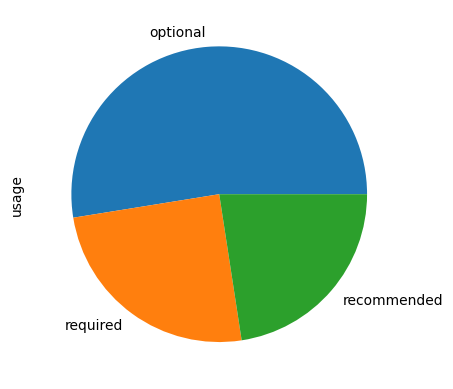

In [136]:
df.usage.value_counts().plot.pie()

<AxesSubplot: ylabel='usage'>

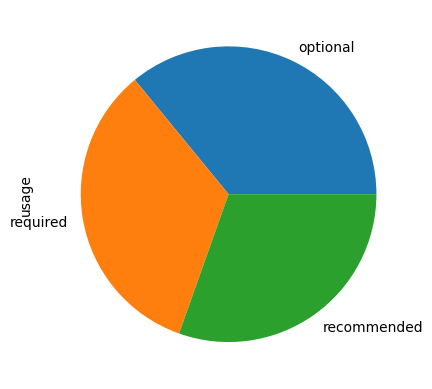

In [135]:
df_final.usage.value_counts().plot.pie()

In [137]:
df_final.category.apply(lambda x: ' > '.join(x.split(' > ')[:2]) in L2s).all()

True

In [138]:
df_final = df_final.sort_values(['category', 'attribute_field'])

In [139]:
len(df_no_freetext) / len(df), len(df_final) / len(df)

(0.6674227050256655, 0.7397636385340814)

In [140]:
df_final['L2'] = df_final.category.apply(lambda x: ' > '.join(x.split(' > ')[:2]))

In [141]:
df_final.groupby('L2').agg({'category': lambda x: len(set([i for i in x]))})

,category
L2,
Cellphones & Telecommunications > Mobile Phone Accessories,29
Cellphones & Telecommunications > Phone Bags & Cases,4
Consumer Electronics > Earphones & Headphones,4
"Home & Garden > Arts, Crafts & Sewing",110
Home & Garden > Festive & Party Supplies,55
Home & Garden > Garden Supplies,79
Home & Garden > Home Decor,63
Home & Garden > Home Storage & Organization,45
Home & Garden > Home Textile,46


In [142]:
df_final.groupby('L2').agg({'attribute_field': lambda x: len(set([i for i in x]))})

,attribute_field
L2,
Cellphones & Telecommunications > Mobile Phone Accessories,34
Cellphones & Telecommunications > Phone Bags & Cases,14
Consumer Electronics > Earphones & Headphones,24
"Home & Garden > Arts, Crafts & Sewing",29
Home & Garden > Festive & Party Supplies,44
Home & Garden > Garden Supplies,29
Home & Garden > Home Decor,61
Home & Garden > Home Storage & Organization,25
Home & Garden > Home Textile,44


In [143]:
df_final.groupby('L2').agg({'attribute_field': lambda x: len(set([i for i in x]))}).mean()

attribute_field    29.36
dtype: float64

In [144]:
df_final.groupby('L2').agg({'attribute_field': lambda x: len(set([i for i in x]))}).sum()

attribute_field    734
dtype: int64

<AxesSubplot: ylabel='Frequency'>

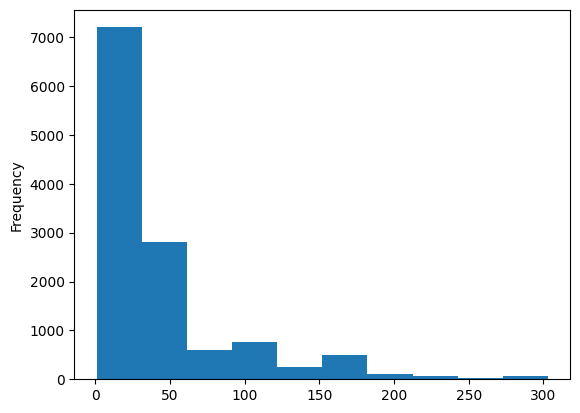

In [145]:
df_final.category_attributevalue.apply(lambda x: len(eval(x))).plot.hist()

<AxesSubplot: ylabel='augment'>

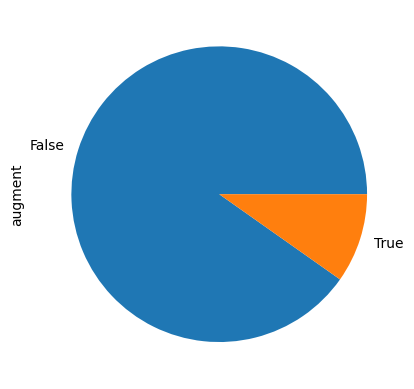

In [146]:
df_final.augment.value_counts().plot.pie()

In [149]:
df_final[df_final.augment].sample(2).to_dict('records')

[{'category': 'Sports > Fishing > Fishing Apparel > Fishing Pants',
  'attribute_field': 'Brand Name',
  'category_attributevalue': "['Abu Garcia', 'Berkley', 'Cabela\\'s', 'Columbia', 'Daiwa', 'Frogg Toggs', 'Gander Mountain', 'Huk', 'KastKing', 'Lews', 'Mustad', 'Okuma', 'Penn', 'Rapala', 'Shimano', 'Simms', 'St. Croix', 'Ugly Stik', 'Under Armour', 'Wright & McGill']",
  'description': 'Specifies the brand or manufacturer of the product.',
  'augment': True,
  'usage': 'optional',
  'L2': 'Sports > Fishing'},
 {'category': 'Home & Garden > Home Storage & Organization > Clothing & Wardrobe Storage > Space Separation Tools',
  'attribute_field': 'Brand Name',
  'category_attributevalue': "['Alera', 'Ameriwood Home', 'ClosetMaid', 'EZOWare', 'Furinno', 'Honey-Can-Do', 'IRIS USA', 'John Louis Home', 'Kousi', 'Lifewit', 'Mainstays', 'mDesign', 'ORG', 'Oriental Furniture', 'Seville Classics', 'Simple Houseware', 'Sorbus', 'StorageManiac', 'TomCare', 'Whitmor', 'Zober']",
  'description': 

In [151]:
df_final.to_csv('attribute_definition_top25L2_filtered_augmented_01162023.csv', index=False)